In [1]:
%%capture state
from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('../')

import tensorflow as tf
import numpy as np

from models.neural_network import NeuralNetwork
from models.cnn import CNN

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

#Seed used for all calculations of training and test point indices 
SEED = 14

In [2]:
## Visualization of samples
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(image):
    plt.figure(figsize=(1, 1))
    if image.shape[-1] == 1:
        # image is in black and white
        image = image[:, :, 0]
        plt.imshow(image, cmap='Greys')
    else:
        # image is in color
        plt.imshow(image)
    plt.axis('off')
    plt.show()

#Normalize rows of a given matrix
def normalize(matrix):
    matrix_nm = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        matrix_nm[i] = matrix[i]/np.linalg.norm(matrix[i]) 
    return matrix_nm

In [3]:
#Load model from disk
model_name = 'SVHN-Pool'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='svhn_pool')
model.load_model(model_save_path, weights_save_path)    
#epochs = 50
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

Loaded model from disk


In [4]:
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [5]:
num_test_samples_per_class = 10
num_test_samples = 10*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
noisy_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='Noisy', eps=0.1)
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM', eps=0.1)
bim_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM', iterations=10, eps=0.1)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False, eps=0.1)
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF')
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='JSMA')

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "


In [6]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='svhn_pool')
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


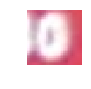

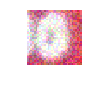

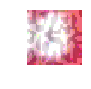

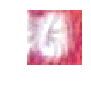

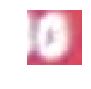

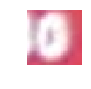

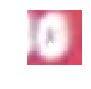

In [7]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 1)
visualize(reg_data[x_vis].reshape(32,32,3))
visualize(noisy_data[x_vis].reshape(32,32,3))
visualize(fgsm_data[x_vis].reshape(32,32,3))
visualize(bim_data[x_vis].reshape(32,32,3))
visualize(cw_data[x_vis].reshape(32,32,3))
visualize(df_data[x_vis].reshape(32,32,3))
visualize(jsma_data[x_vis].reshape(32,32,3))

In [9]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,32,32,3))
noisy_preds = model.model.predict(noisy_data.reshape(-1,32,32,3))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,32,32,3))
bim_preds = model.model.predict(bim_data.reshape(-1,32,32,3))
cw_preds = model.model.predict(cw_data.reshape(-1,32,32,3))
df_preds = model.model.predict(df_data.reshape(-1,32,32,3))
jsma_preds = model.model.predict(jsma_data.reshape(-1,32,32,3))

In [10]:
#Convert preds to labels
reg_labels = np.zeros(reg_preds.shape)
reg_labels[np.arange(num_test_samples),np.argmax(reg_preds, axis=1)] = 1

noisy_labels = np.zeros(noisy_preds.shape)
noisy_labels[np.arange(num_test_samples),np.argmax(noisy_preds, axis=1)] = 1

fgsm_labels = np.zeros(fgsm_preds.shape)
fgsm_labels[np.arange(num_test_samples),np.argmax(fgsm_preds, axis=1)] = 1

bim_labels = np.zeros(bim_preds.shape)
bim_labels[np.arange(num_test_samples),np.argmax(bim_preds, axis=1)] = 1

cw_labels = np.zeros(cw_preds.shape)
cw_labels[np.arange(num_test_samples),np.argmax(cw_preds, axis=1)] = 1

df_labels = np.zeros(df_preds.shape)
df_labels[np.arange(num_test_samples),np.argmax(df_preds, axis=1)] = 1


jsma_labels = np.zeros(jsma_preds.shape)
jsma_labels[np.arange(num_test_samples),np.argmax(jsma_preds, axis=1)] = 1

In [11]:
#Check preds to ensure adversarial samples were generated correctly
print (np.argmax(reg_preds, axis=1))
print (np.argmax(noisy_preds, axis=1))
print (np.argmax(fgsm_preds, axis=1))
print (np.argmax(bim_preds, axis=1))
print (np.argmax(cw_preds, axis=1))
print (np.argmax(df_preds, axis=1))
print (np.argmax(jsma_preds, axis=1))

[0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 6 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 1 7 7 7
 7 7 7 7 7 7 8 8 8 0 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]
[0 0 0 8 0 0 0 0 0 0 1 2 1 2 1 1 1 1 1 1 2 2 2 2 3 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 6 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 1 7 7 7
 7 7 7 7 7 2 6 8 8 2 3 8 8 8 8 8 9 3 9 4 2 9 9 9 9 9]
[2 8 8 5 5 5 5 3 4 2 5 2 6 0 3 5 2 3 5 7 5 3 9 2 3 0 3 3 2 3 2 2 3 2 3 5 5
 8 9 6 2 2 3 5 2 2 3 8 3 2 6 8 6 6 5 4 2 2 1 7 2 7 3 3 2 2 8 3 2 5 1 2 2 3
 3 2 9 5 2 2 6 2 3 2 6 3 5 2 6 4 3 3 2 2 3 0 4 2 4 3]
[9 2 3 6 6 5 6 2 4 2 5 1 8 2 3 4 8 0 6 7 5 7 8 4 3 0 3 7 9 3 6 9 4 2 9 9 5
 0 2 6 7 3 3 2 2 2 2 5 7 2 6 6 5 6 6 2 6 3 6 2 3 9 5 9 8 0 5 1 5 5 7 2 2 2
 2 2 2 2 2 2 6 7 3 4 6 3 9 2 6 6 2 2 8 2 2 0 4 2 2 3]
[9 2 6 6 6 9 6 2 6 2 5 1 8 2 3 2 8 0 6 7 5 3 9 0 3 0 3 3 3 3 2 2 4 2 9 9 5
 0 2 5 2 2 3 2 2 2 2 5 2 2 6 6 5 6 3 6 6 3 6 3 2 0 5 8 8 0 4 1 5 5 7 2 2 2
 2 2 2 2 2 2 6 6 3 4 6 6 9 2 6 6 2

In [12]:
#Get gradients for all test points
grads_reg = model.get_gradients_wrt_params(reg_data, reg_labels)
grads_noisy = model.get_gradients_wrt_params(noisy_data, noisy_labels)
grads_fgsm = model.get_gradients_wrt_params(fgsm_data, fgsm_labels)
grads_bim = model.get_gradients_wrt_params(bim_data, bim_labels)
grads_cw = model.get_gradients_wrt_params(cw_data, cw_labels)
grads_df = model.get_gradients_wrt_params(df_data, df_labels)
grads_jsma = model.get_gradients_wrt_params(jsma_data, jsma_labels)
#Get gradients for training points 
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)

In [13]:
grads_reg_nm = normalize(grads_reg)
grads_noisy_nm = normalize(grads_noisy)
grads_fgsm_nm = normalize(grads_fgsm)
grads_bim_nm = normalize(grads_bim)
grads_cw_nm = normalize(grads_cw)
grads_df_nm = normalize(grads_df)
grads_jsma_nm = normalize(grads_jsma)
grads_train_nm = normalize(grads_train)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [14]:
#Get norms 
grads_reg_norms = np.sqrt(np.dot(grads_reg, grads_reg.T)).diagonal()
grads_noisy_norms = np.sqrt(np.dot(grads_noisy, grads_noisy.T)).diagonal()
grads_bim_norms = np.sqrt(np.dot(grads_bim, grads_bim.T)).diagonal()
grads_fgsm_norms = np.sqrt(np.dot(grads_fgsm, grads_fgsm.T)).diagonal()
grads_cw_norms = np.sqrt(np.dot(grads_cw, grads_cw.T)).diagonal()
grads_df_norms = np.sqrt(np.dot(grads_df, grads_df.T)).diagonal()
grads_jsma_norms = np.sqrt(np.dot(grads_jsma, grads_jsma.T)).diagonal()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [15]:
#Get cosine similarity matrix
cos_sim_reg = np.dot(grads_reg_nm, grads_train_nm.T)
cos_sim_noisy = np.dot(grads_noisy_nm, grads_train_nm.T)
cos_sim_fgsm = np.dot(grads_fgsm_nm, grads_train_nm.T)
cos_sim_bim = np.dot(grads_bim_nm, grads_train_nm.T)
cos_sim_cw = np.dot(grads_cw_nm, grads_train_nm.T)
cos_sim_df = np.dot(grads_df_nm, grads_train_nm.T)
cos_sim_jsma = np.dot(grads_jsma_nm, grads_train_nm.T)

In [21]:
#Separate Using Cos Sim

eta = 0.41

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim[i]) > eta:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))


Regular: 0.8700
Noisy:  0.6800
FGSM:  0.1000
BIM:  0.7500
CW: 0.1900
DF: 0.0900
JSMA: 0.0900


In [25]:
#Separate using just norm
gamma = 3

count = 0.0
for i in range(num_test_samples):
    if grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_norms[i] < gamma:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))




Regular: 0.8500
Noisy:  0.6500
FGSM:  0.2900
BIM:  1.0000
CW: 0.1700
DF: 0.0000
JSMA: 0.0100


In [26]:
#Use both

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta and grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta and grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta and grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim[i]) > eta and grads_bim_norms[i] < gamma:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta and grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta and grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta and grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))


Regular: 0.8000
Noisy:  0.6200
FGSM:  0.1000
BIM:  0.7500
CW: 0.1200
DF: 0.0000
JSMA: 0.0100


In [27]:
def avg_l2_distortion(orig, adv):
    """Get the mean l2 distortion between two orig and adv images"""
    l2_dist = 0.0
    for i in range(orig.shape[0]):
        l2_dist+= np.linalg.norm(orig[i] - adv[i])
    return l2_dist/orig.shape[0]

In [28]:
print (avg_l2_distortion(reg_data, fgsm_data))
print (avg_l2_distortion(reg_data, bim_data))
print (avg_l2_distortion(reg_data, cw_data))
print (avg_l2_distortion(reg_data, df_data))
print (avg_l2_distortion(reg_data, jsma_data))

5.47005793571
2.96338005781
1.48370975256
0.439847521139
2.68037403703
